In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S

pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import (fits, ascii)

# Observation Definitions

Functions to create and optimize a series of observation objects stored as a dictionary.

In [ ]:
pynrc.NIRCam()

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

# Sources and Bandpasses

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [177]:
# List of filters
args_filter = [('F070W', None, None),
               ('F115W', None, None),
               ('F277W', None, None),
               ('F444W', None, None),
               ('F140M', None, None),
               ('F182M', None, None),
               ('F300M', None, None),
               ('F335M', None, None)]


# and their dictionary keys
filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'Cluster/'

# Directory to save plots and figures
outdir  = 'Cluster/'

In [7]:
import os
files = [f for f in os.listdir(votdir) if f.endswith('.vot')]

In [20]:
from astropy.io.votable import parse_single_table
from pynrc.maths import robust

def gen_table(votable_file):
    """Read VOTable and convert to astropy table"""
    # Import source SED from VOTable
    table = parse_single_table(votable_file)
    # Convert to astropy table
    tbl = table.to_table()

    freq = tbl['sed_freq'] * 1e9 # Hz
    wave_m = 2.99792458E+08 / freq
    wave_A = 1e10 * wave_m

    # Add wavelength column
    col = tbl.Column(wave_A, 'sed_wave')
    col.unit = 'Angstrom'
    tbl.add_column(col)

    # Sort flux monotomically with wavelength
    tbl.sort(['sed_wave', 'sed_flux'])

    return tbl

def combine_fluxes(table):
    """Average duplicate data points

    Creates average of duplicate point stored in self.sp_phot.
    """

    wave = table['sed_wave']
    flux = table["sed_flux"]
    eflux = table["sed_eflux"]

    # Average duplicate data points
    uwave, ucnt = np.unique(wave, return_counts=True)
    uflux = []
    uflux_e = []
    for i, w in enumerate(uwave):
        ind = (wave==w)
        flx = np.median(flux[ind]) if ucnt[i]>1 else flux[ind][0]
        uflux.append(flx)

        eflx = robust.medabsdev(flux[ind]) if ucnt[i]>1 else eflux[ind][0]
        uflux_e.append(eflx)
    uflux = np.array(uflux)
    uflux_e = np.array(uflux_e)

    # Photometric data points
    sp_phot = S.ArraySpectrum(uwave, uflux, 
                              waveunits=wave.unit.name, 
                              fluxunits=flux.unit.name)
    sp_phot.convert('Angstrom')
    sp_phot.convert('Flam')

    sp_phot_e = S.ArraySpectrum(uwave, uflux_e, 
                                waveunits=wave.unit.name, 
                                fluxunits=eflux.unit.name)
    sp_phot_e.convert('Angstrom')
    sp_phot_e.convert('Flam')


    return (sp_phot, sp_phot_e)


In [26]:
from astropy.io.votable import parse_single_table

In [159]:
f = votdir + files[-1]
sp_arr = []
for file in files:
    print(file)
    f = votdir + file
    sp = nrc_utils.source_spectrum('Test', 'M0V', 20, bp_k, f)
    sp.fit_SED(wlim=[0.1,0.7], robust=False, use_err=False, IR_excess=False, verbose=False)
    obs = S.Observation(sp.sp_model, bp_v, binset=bp_v.wave)
    sp = nrc_utils.source_spectrum('Test', 'M0V', obs.effstim('vegamag'), bp_v, f)
    sp.fit_SED(wlim=[0.7,10], robust=False, use_err=False, IR_excess=True, verbose=False)
    sp_arr.append(sp.sp_model)
    #sp.plot_SED(xr=[0.1,10])

J054137.36-015247.4.vot
J054137.74-015351.8.vot
J054137.75-015351.7.vot
J05413733-0153132.vot
J05413774-0153514.vot
J05413787-0153137.vot
J05413789-0153112.vot
J054138.49-015323.8.vot
J05413807-0153572.vot
J05413824-0153090.vot
J05413831-0153282.vot
J05413832-0153331.vot
J05413858-0153227.vot
J054139.09-015358.6.vot
J054139.13-015206.5.vot
J054139.13-015207.3.vot
J05413908-0153582.vot
J05413948-0153268.vot
J054140.39-015220.5.vot
J05414249-0154097.vot
J054146.28-015348.1.vot


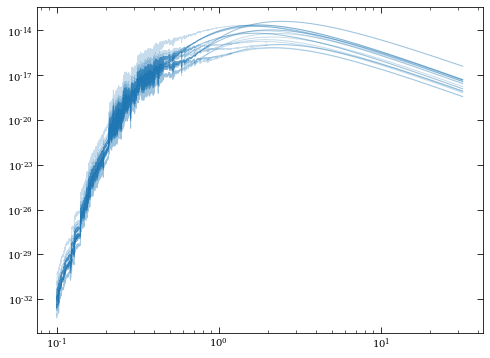

In [160]:
for sp in sp_arr:
    plt.loglog(sp.wave/1e4, sp.flux, color='C0', lw=1, alpha=0.25)

In [161]:
from astropy.table import Table

In [178]:

filt_names = []
mag_data = []
for args in args_filter:
    filt = args[0]
    print(filt)
    
    filt_names.append(filt)
    bp = pynrc.read_filter(filt)
    
    mag_arr = []
    for sp in sp_arr:
        obs = S.Observation(sp, bp, binset=bp.wave)
        mag_arr.append(obs.effstim('vegamag'))
        
    mag_arr = np.array(mag_arr)
    mag_data.append(mag_arr)


F070W
F115W
F277W
F444W
F140M
F182M
F300M
F335M


In [179]:
data = [files] + mag_data
names = tuple(['Name'] + filt_names)

In [181]:
tbl = Table(data, names=names)
for fname in filt_names:
    tbl[fname].format = '.2f'

In [182]:
tbl

Name,F070W,F115W,F277W,F444W,F140M,F182M,F300M,F335M
str23,float64,float64,float64,float64,float64,float64,float64,float64
J054137.36-015247.4.vot,15.83,13.76,10.27,9.29,12.78,11.56,10.04,9.77
J054137.74-015351.8.vot,15.01,11.11,7.68,6.88,9.97,8.81,7.48,7.27
J054137.75-015351.7.vot,15.01,11.11,7.68,6.88,9.97,8.81,7.48,7.27
J05413733-0153132.vot,13.58,10.82,8.08,7.42,9.91,8.98,7.91,7.73
J05413774-0153514.vot,15.01,11.11,7.68,6.88,9.97,8.81,7.48,7.27
J05413787-0153137.vot,15.77,12.36,9.13,8.36,11.29,10.19,8.94,8.73
J05413789-0153112.vot,15.77,12.36,9.13,8.36,11.29,10.19,8.94,8.73
J054138.49-015323.8.vot,15.01,11.29,7.94,7.16,10.19,9.05,7.75,7.54
J05413807-0153572.vot,18.19,13.90,9.94,9.01,12.61,11.26,9.71,9.46


In [330]:
np.min(tbl[filt])

13.583926344788829

In [396]:
nrc.bg_zodi(100)

11.258911700144022

In [405]:
# Baseline

sat_arr = []
sen_arr = []
imsat_SH4 = []
for filt in filt_names:
    print(filt)
    nrc = pynrc.NIRCam(filt, read_mode='SHALLOW4', ngroup=2, nint=76)
    satlim = nrc.sat_limits(ngroup=2)['satmag']
    sendict = nrc.sensitivity(sp=sp_bg, nsig=5, units='vegamag', zfact=100)
    senlim = sendict[0]['sensitivity']

    col = tbl[filt]
    ind = np.argwhere(col == np.min(col)).flatten()
    sp = sp_arr[ind[0]]
    imsat = nrc.saturation_levels(sp, ngroup=2, full_size=False)
    
    sat_arr.append(satlim)
    sen_arr.append(senlim)
    imsat_SH4.append(imsat)
        
sat_arr = np.array(sat_arr)
sen_arr = np.array(sen_arr)

# Save to astropy table
data = [filt_names, sen_arr, sat_arr]
names = ('Filter', 'Sen0', 'Sat0')
tbl_compare = Table(data, names=names)
tbl_compare[names[1]].format = '.2f'
tbl_compare[names[2]].format = '.2f'

F070W
F115W
F277W
F444W
F140M
F182M
F300M
F335M


In [406]:
# Get Charge Time < 11.9 hours
# Requires setting NINT = 9 & 8 for a total of (9+8)*4 = 68
# Total Time = 11.79 hrs

#sat_arr = []
#sen_arr = []
#imsat_list = []
#for filt in filt_names:
#    print(filt)
#    nrc = pynrc.NIRCam(filt, read_mode='SHALLOW4', ngroup=2, nint=68)
#    satlim = nrc.sat_limits(ngroup=2)['satmag']
#    sendict = nrc.sensitivity(sp=sp_bg, nsig=5, units='vegamag', zfact=10)
#    senlim = sendict[0]['sensitivity']
#
#    col = tbl[filt]
#    ind = np.argwhere(col == np.min(col)).flatten()
#    sp = sp_arr[ind[0]]
#    imsat = nrc.saturation_levels(sp, ngroup=2, full_size=False)
#    
#    sat_arr.append(satlim)
#    sen_arr.append(senlim)
#    imsat_list.append(imsat)
#    
#sat_arr = np.array(sat_arr)
#sen_arr = np.array(sen_arr)
#
# Save to astropy table
#col = Table.Column(data=sen_arr, name='Sen1', format='.2f')
#tbl_compare.add_column(col)
#col = Table.Column(data=sat_arr, name='Sat1', format='.2f')
#tbl_compare.add_column(col)

In [407]:
# Switch to BRIGHT1 5 Groups
# No change in time

sat_arr = []
sen_arr = []
imsat_BR1 = []
for filt in filt_names:
    print(filt)
    nrc = pynrc.NIRCam(filt, read_mode='BRIGHT1', ngroup=5, nint=68)
    satlim = nrc.sat_limits(ngroup=2)['satmag']
    sendict = nrc.sensitivity(sp=sp_bg, nsig=5, units='vegamag', zfact=100)
    senlim = sendict[0]['sensitivity']

    col = tbl[filt]
    ind = np.argwhere(col == np.min(col)).flatten()
    sp = sp_arr[ind[0]]
    imsat = nrc.saturation_levels(sp, ngroup=2, full_size=False)
    
    sat_arr.append(satlim)
    sen_arr.append(senlim)
    imsat_BR1.append(imsat)
    
sat_arr = np.array(sat_arr)
sen_arr = np.array(sen_arr)

# Save to astropy table
col = Table.Column(data=sen_arr, name='Sen2', format='.2f')
tbl_compare.add_column(col)
col = Table.Column(data=sat_arr, name='Sat2', format='.2f')
tbl_compare.add_column(col)

F070W
F115W
F277W
F444W
F140M
F182M
F300M
F335M


In [408]:
# Eat up the rest of the the time
# Adds a 3rd visit with 4 additional INTs per filter

sat_arr = []
sen_arr = []
imsat_BR1 = []
for filt in filt_names:
    print(filt)
    nrc = pynrc.NIRCam(filt, read_mode='BRIGHT1', ngroup=5, nint=72)
    satlim = nrc.sat_limits(ngroup=2)['satmag']
    sendict = nrc.sensitivity(sp=sp_bg, nsig=5, units='vegamag', zfact=100)
    senlim = sendict[0]['sensitivity']

    col = tbl[filt]
    ind = np.argwhere(col == np.min(col)).flatten()
    sp = sp_arr[ind[0]]
    imsat = nrc.saturation_levels(sp, ngroup=2, full_size=False)
    
    sat_arr.append(satlim)
    sen_arr.append(senlim)
    imsat_BR1.append(imsat)
    
sat_arr = np.array(sat_arr)
sen_arr = np.array(sen_arr)

# Save to astropy table
col = Table.Column(data=sen_arr, name='Sen2r1', format='.2f')
tbl_compare.add_column(col)
col = Table.Column(data=sat_arr, name='Sat2r1', format='.2f')
#tbl_compare.add_column(col)

F070W
F115W
F277W
F444W
F140M
F182M
F300M
F335M


In [409]:
# Include INTRAMODULEBOX dithers (x4)
# Switch to Small Grid Dithers (x4)
# Reduction to NINT = 64
# Total Time = 11.55 hrs

sat_arr = []
sen_arr = []
imsat_list = []
for filt in filt_names:
    print(filt)
    nrc = pynrc.NIRCam(filt, read_mode='BRIGHT1', ngroup=5, nint=64)
    satlim = nrc.sat_limits(ngroup=2)['satmag']
    sendict = nrc.sensitivity(sp=sp_bg, nsig=5, units='vegamag', zfact=100)
    senlim = sendict[0]['sensitivity']

    col = tbl[filt]
    ind = np.argwhere(col == np.min(col)).flatten()
    sp = sp_arr[ind[0]]
    imsat = nrc.saturation_levels(sp, ngroup=2, full_size=False)
    
    sat_arr.append(satlim)
    sen_arr.append(senlim)
    imsat_list.append(imsat)
    
sat_arr = np.array(sat_arr)
sen_arr = np.array(sen_arr)

# Save to astropy table
col = Table.Column(data=sen_arr, name='Sen3', format='.2f')
tbl_compare.add_column(col)
col = Table.Column(data=sat_arr, name='Sat3', format='.2f')
#tbl_compare.add_column(col)

F070W
F115W
F277W
F444W
F140M
F182M
F300M
F335M


In [410]:
# Eat up the rest of the the time
# Adds a 3rd visit with 6 additional INTs per filter

sat_arr = []
sen_arr = []
imsat_list = []
for filt in filt_names:
    print(filt)
    nrc = pynrc.NIRCam(filt, read_mode='BRIGHT1', ngroup=5, nint=70)
    satlim = nrc.sat_limits(ngroup=2)['satmag']
    sendict = nrc.sensitivity(sp=sp_bg, nsig=5, units='vegamag', zfact=100)
    senlim = sendict[0]['sensitivity']

    col = tbl[filt]
    ind = np.argwhere(col == np.min(col)).flatten()
    sp = sp_arr[ind[0]]
    imsat = nrc.saturation_levels(sp, ngroup=2, full_size=False)
    
    sat_arr.append(satlim)
    sen_arr.append(senlim)
    imsat_list.append(imsat)
    
sat_arr = np.array(sat_arr)
sen_arr = np.array(sen_arr)

# Save to astropy table
col = Table.Column(data=sen_arr, name='Sen3r1', format='.2f')
tbl_compare.add_column(col)
col = Table.Column(data=sat_arr, name='Sat3r1', format='.2f')
#tbl_compare.add_column(col)

F070W
F115W
F277W
F444W
F140M
F182M
F300M
F335M


In [413]:
new_order = ('Filter', 'Sen0', 'Sen2', 'Sen2r1', 'Sen3', 'Sen3r1', 'Sat0', 'Sat2')
tbl_compare = tbl_compare[new_order]
tbl_compare.rename_column('Sat0', 'Sat_SH4')
tbl_compare.rename_column('Sat2', 'Sat_BR1')

In [414]:
tbl_compare

Filter,Sen0,Sen2,Sen2r1,Sen3,Sen3r1,Sat_SH4,Sat_BR1
str5,float64,float64,float64,float64,float64,float64,float64
F070W,25.99,26.10,26.13,26.07,26.12,17.40,16.21
F115W,25.91,26.06,26.09,26.03,26.08,17.78,16.59
F277W,24.48,24.66,24.69,24.63,24.67,17.09,15.90
F444W,22.93,23.12,23.15,23.09,23.14,15.40,14.21
F140M,25.28,25.39,25.42,25.36,25.41,16.66,15.47
F182M,25.11,25.23,25.26,25.20,25.24,16.24,15.05
F300M,23.80,23.95,23.99,23.92,23.97,15.74,14.55
F335M,23.64,23.80,23.83,23.77,23.82,15.48,14.28


In [370]:
tbl_compare

Filter,Sen0,Sat0,Sen1,Sat1,Sen2,Sat2,Sen3,Sat3
str5,float64,float64,float64,float64,float64,float64,float64,float64
F070W,26.90,17.40,26.84,17.40,26.76,16.21,26.72,16.21
F115W,27.06,17.78,27.00,17.78,26.94,16.59,26.91,16.59
F277W,26.01,17.09,25.95,17.09,25.97,15.90,25.94,15.90
F444W,24.70,15.40,24.64,15.40,24.74,14.21,24.71,14.21
F140M,26.16,16.66,26.10,16.66,26.01,15.47,25.98,15.47
F182M,26.03,16.24,25.97,16.24,25.89,15.05,25.86,15.05
F300M,24.97,15.74,24.91,15.74,24.87,14.55,24.84,14.55
F335M,24.85,15.48,24.79,15.48,24.75,14.28,24.72,14.28


In [328]:
nrc.sensitivity(sp=sp_bg, nsig=5, units='vegamag')['sensitivity']

({'Spectrum': 'Flat spectrum in photlam',
  'nsig': 5,
  'sensitivity': 26.899707136356472,
  'units': 'vegamag'},
 {'Spectrum': 'Flat spectrum in photlam',
  'nsig': 5,
  'sensitivity': 23.38876800288095,
  'units': 'vegamag/arcsec^2'})

In [320]:
_ = nrc1.sat_limits(verbose=True, ngroup=2)
_ = nrc2.sat_limits(verbose=True, ngroup=2)

F070W Saturation Limit assuming G2V source: 17.40 vegamag
F070W Saturation Limit assuming G2V source: 16.21 vegamag


In [321]:
sp_bg = pynrc.stellar_spectrum('flat', 25, 'vegamag', bp_k)

In [322]:
_ = nrc1.sensitivity(sp=sp_bg, nsig=5, forwardSNR=False, units='vegamag', verbose=True)
_ = nrc2.sensitivity(sp=sp_bg, nsig=5, forwardSNR=False, units='vegamag', verbose=True)

Point Source Sensitivity (5-sigma): 26.90 vegamag
Surface Brightness Sensitivity (5-sigma): 23.39 vegamag/arcsec^2
Point Source Sensitivity (5-sigma): 26.72 vegamag
Surface Brightness Sensitivity (5-sigma): 23.21 vegamag/arcsec^2


In [223]:

res = nrc.ramp_optimize(sp_bg, sp_bright=sp_arr[3], tacq_max=4500, ng_min=2, 
                        ng_max=5, well_frac_max=40, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM2       2   30    128.84   3865.24   4187.35    191.5   36.451    2.959
MEDIUM2       2   31    128.84   3994.08   4326.92    194.7   36.451    2.959
MEDIUM2       2   32    128.84   4122.92   4466.50    197.8   36.451    2.959
MEDIUM2       2   33    128.84   4251.76   4606.08    200.9   36.451    2.959
MEDIUM2       2   34    128.84   4380.60   4745.66    203.9   36.451    2.959
SHALLOW2      3   30    128.84   3865.24   4187.35    190.8   36.451    2.948
SHALLOW2      3   31    128.84   3994.08   4326.92    193.9   36.451    2.948
SHALLOW2      3   32    128.84   4122.92   4466.50    197.0   36.451    2.948
SHALLOW2      3   33    128.84   4251.76   4606.08    200.1   36.451    2.948
SHALLOW2      3   34    128.84   4380.60   4745.66    203.1   36.451    2.

In [224]:
from pynrc.pynrc_core import table_filter

res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID         5   68     53.68   3650.50   4380.61    114.0   15.188    1.722
RAPID         5   69     53.68   3704.19   4445.03    114.8   15.188    1.722
BRIGHT1       5   40     96.63   3865.24   4294.71    160.2   27.338    2.443
BRIGHT1       5   41     96.63   3961.87   4402.08    162.2   27.338    2.443
BRIGHT2       5   36    107.37   3865.24   4251.77    186.1   30.375    2.853
BRIGHT2       5   37    107.37   3972.60   4369.87    188.6   30.375    2.853
SHALLOW2      3   30    128.84   3865.24   4187.35    190.8   36.451    2.948
SHALLOW2      3   31    128.84   3994.08   4326.92    193.9   36.451    2.948
SHALLOW4      2   40     96.63   3865.24   4294.71    156.0   27.338    2.379
SHALLOW4      2   41     96.63   3961.87   4402.08    157.9   27.338    2.379
MEDIUM2       2   30    128.84   3865.24   4187.35    191.5   36

In [262]:
imsat1 = nrc1.saturation_levels(sp_arr[3], ngroup=2, full_size=False)
imsat2 = nrc2.saturation_levels(sp_arr[3], ngroup=2, full_size=False)

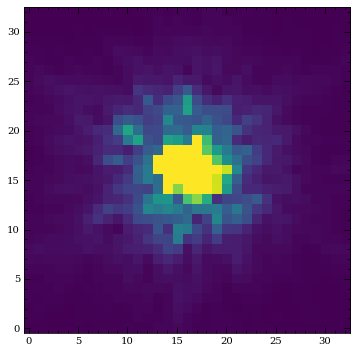

In [264]:
plt.imshow(imsat1, vmax=0.8)

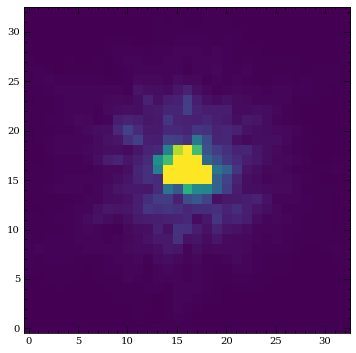

In [265]:
plt.imshow(imsat2, vmax=0.8)